# Modèle : MNIST

groupe : 
- Tristan Nobre
- Clément Zelter
- Erwan Gautier
- Mathieu Andriamiraho

L'objectif de ce notebook est de relever un challenge en travaillant sur un dataset. Ici, nous utilisons le dataset MNIST, conçu par Yann LeCun. L'objectif principal du challenge est d'obtenir la meilleure précision (accuracy) possible. Pour y parvenir, nous avons mené de nombreux tests de manière empirique afin d'identifier le modèle le plus performant tout en évitant le surapprentissage.

### Importer toutes les bibliothèques nécessaires.

Afin de réaliser ce challenge, nous utilisons les bibliothèques standard pour la reconnaissance de caractéristiques sur des images :

- `numpy` : pour la manipulation des tableaux de données et des opérations numériques.
- `tensorflow` et `keras` : pour construire, entraîner et évaluer des modèles de deep learning.
- `matplotlib.pyplot` : pour la visualisation des données, notamment l'affichage des images du dataset.
- `sklearn.datasets.fetch_openml` : pour récupérer le dataset MNIST depuis OpenML.
- `sklearn.model_selection.train_test_split` : pour diviser le dataset en ensembles d'entraînement et de test.
- `sklearn.preprocessing.LabelBinarizer` : pour encoder les labels sous forme binaire, ce qui facilite l'entraînement du modèle.

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

### Charger l'ensemble de données MNIST 

MNIST étant un dataset très connu il est inclu dans la fonction `fetch_openml` de `sklearn.datasets`

Nous normalisons les données en divisant par 255.0 afin de ramener les valeurs entre `0` et `1` pour faciliter l'entrainement du modèle

Enfin on transforme chaque label (chiffre de 0 à 9) en un vecteur binaire de taille `10` permettant au modèle de mieux gérer la classification multi-classe

In [13]:
mnist = fetch_openml('mnist_784', version=1)
x, y = mnist.data / 255.0, mnist.target.astype(int)
y = LabelBinarizer().fit_transform(y)  # One-hot encoding des labels

### Séparation entre la formation et les tests

De manière générale, il est recommandé, lorsqu'on dispose d'un seul dataset, de le diviser en deux parties : une pour l'entraînement et une pour les tests. Ici, nous utilisons un ratio de `20%` du dataset pour les tests, ce qui nous rappelle la loi de Pareto.

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Création du model 

La création du modèle est l'une des étapes les plus importantes de ce notebook. En effet, c'est l'architecture du réseau neuronal qui détermine ses performances. Vous remarquerez le commentaire 'Fourth model' au-dessus de l'affectation de la variable model. Il s'agit du quatrième modèle testé après de nombreuses recherches et expérimentations. Cette architecture a finalement été choisie comme la plus efficace pour traiter les images du dataset MNIST.

`TLDR` : 
- Ce modèle utilise **deux blocs convolutifs** suivis de normalisation et de pooling.  
- Une phase **dense** finale permet d'exploiter les caractéristiques extraites.  
- L'ajout de **Dropout et Batch Normalization** améliore la stabilité et réduit le surapprentissage.  
- L'activation **softmax** en sortie permet la classification des images.  

##### 1. **Couches Convolutives et Normalisation**
- **`Conv2D(32, (3, 3), activation='relu', padding='same')`**  
  → Première couche de convolution avec 32 filtres de taille 3×3.  
  → `padding='same'` conserve la taille d'entrée.  
  → Activation ReLU pour introduire la non-linéarité.  
- **`BatchNormalization()`**  
  → Normalisation pour stabiliser l'entraînement et accélérer la convergence.  
- **Deuxième `Conv2D(32, (3, 3), activation='relu', padding='same')` + `BatchNormalization()`**  
  → Ajout d'une deuxième convolution identique pour capturer plus de caractéristiques.  

##### 2. **Réduction de Dimension et Régularisation**
- **`MaxPooling2D((2, 2))`**  
  → Réduction de la taille des feature maps par un facteur de 2.  
- **`Dropout(0.25)`**  
  → Désactivation aléatoire de 25 % des neurones pour éviter le surapprentissage.  

##### 3. **Bloc Convolutif Profond**
- **Deux couches `Conv2D(64, (3, 3), activation='relu', padding='same')` avec `BatchNormalization()`**  
  → Augmente le nombre de filtres à 64 pour extraire des caractéristiques plus complexes.  
- **`MaxPooling2D((2, 2))` + `Dropout(0.25)`**  
  → Nouvelle réduction de dimension et régularisation.  

##### 4. **Couches Denses et Classification**
- **`Flatten()`**  
  → Transforme les feature maps en un vecteur pour les couches denses.  
- **`Dense(256, activation='relu')` + `BatchNormalization()` + `Dropout(0.5)`**  
  → Ajoute une couche dense avec 256 neurones pour interpréter les caractéristiques.  
  → `Dropout(0.5)` pour éviter le surapprentissage.  
- **`Dense(10, activation='softmax')`**  
  → Couche de sortie avec 10 neurones correspondant aux 10 classes de chiffres (0-9).  
  → `softmax` génère des probabilités pour chaque classe.  


In [ ]:
# Fourth model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                        input_shape=(28, 28, 1)),  # First convolutional layer
    keras.layers.BatchNormalization(),  # Normalize activations

    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),     # Downsample feature maps
    keras.layers.Dropout(0.25),            # Prevent overfitting

    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),                # Flatten for the dense layers
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')  # Output layer for 10 classes
])

/home/mathieu/code/mnist/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

### Compilation du model 

Il est ensuite nécessaire de compiler le modèle, ce qui définit la manière dont il sera configuré pour son entraînement. Pour cela, nous précisons plusieurs paramètres : l'optimiseur (`Adam`) avec un taux d'apprentissage de `0.001`, la fonction de perte (`categorical_crossentropy`), adaptée à la classification multi-classes, et enfin la métrique d'évaluation, ici accuracy, qui mesure la proportion de prédictions correctes. Pour une évaluation plus approfondie, il aurait également été intéressant d'utiliser le score `F1`.

On utilise des fonction de dit de callbacks qui auront différents utilisations :
- la fonction `checkpoint` ici sauvegarde automatiquement le meilleur modèle en fonction de `val_accuracy` 
- on utilise de l'"early stopping" pour arrêter l'entrainement dans le cas le modèle ne s'améliore pas pendant 10 epochs
- enfin on utilise une réduction du taux d'apprentissage afin d'améliorer la convergence

In [18]:
checkpoint = keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1
)

In [19]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy'
    ]
)

### Entrainement du modèle avec 60 epochs

Nous entraînons notre modèle sur un maximum arbitraire de 60 epochs. L'objectif est de trouver un équilibre : un nombre de cycles suffisant pour un apprentissage efficace, tout en évitant un surentraînement. Si le modèle atteint un point où l'entraînement devient inutile, la fonction Early Stopping interrompra automatiquement la boucle d'entraînement

In [20]:
history = model.fit(
    x_train, y_train,
    epochs=60,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/60
875/875 ━━━━━━━━━━━━━━━━━━━━ 84s 94ms/step - accuracy: 0.8898 - loss: 0.3608 - val_accuracy: 0.9689 - val_loss: 0.0935 - learning_rate: 0.0010
Epoch 2/60
875/875 ━━━━━━━━━━━━━━━━━━━━ 80s 92ms/step - accuracy: 0.9790 - loss: 0.0657 - val_accuracy: 0.9857 - val_loss: 0.0420 - learning_rate: 0.0010
Epoch 3/60
875/875 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - accuracy: 0.9843 - loss: 0.0497 - val_accuracy: 0.9891 - val_loss: 0.0355 - learning_rate: 0.0010
Epoch 4/60
875/875 ━━━━━━━━━━━━━━━━━━━━ 81s 93ms/step - accuracy: 0.9867 - loss: 0.0415 - val_accuracy: 0.9825 - val_loss: 0.0567 - learning_rate: 0.0010
Epoch 5/60
875/875 ━━━━━━━━━━━━━━━━━━━━ 81s 93ms/step - accuracy: 0.9888 - loss: 0.0357 - val_accuracy: 0.9865 - val_loss: 0.0421 - learning_rate: 0.0010
Epoch 6/60
875/875 ━━━━━━━━━━━━━━━━━━━━ 81s 92ms/step - accuracy: 0.9897 - loss: 0.0324 - val_accuracy: 0.9701 - val_loss: 0.0860 - learning_rate: 0.0010
Epoch 7/60
875/875 ━━━━━━━━━━━━━━━━━━━━ 82s 93ms/step - accuracy: 0.9907 - l

### Loading the best weights

On enregistre le modèle afin de réutiliser les poids du modèle pour une réutilisation probable

In [21]:
model.load_weights('best_model.keras')

### Evaluation


On utilise alors nos données de tests afin de mesurer la précision de notre modèle créé précédemment.

In [24]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Accuracy sur le test set : {accuracy * 100:.2f}%')

438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9955 - loss: 0.0197
Accuracy sur le test set : 99.59%


### Affichage des courbes d'apprentissage

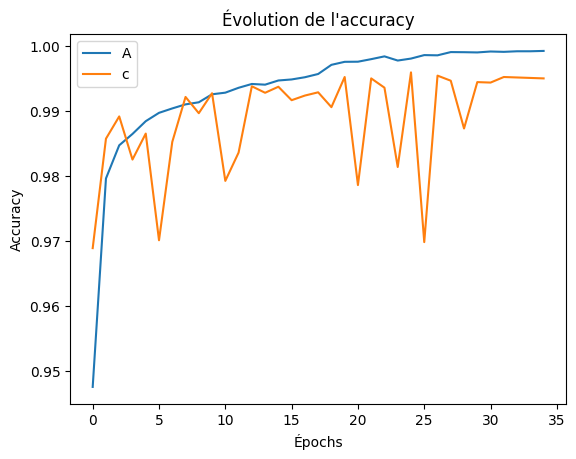

In [23]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Épochs')
plt.ylabel('Accuracy')
plt.legend("Accuracy")
plt.title('Évolution de l\'accuracy')
plt.show()


### Conclusion

**Premier modèle**

Le premier modèle consiste en une architecture simple utilisant uniquement des couches Dense, avec un taux d’apprentissage de 0.001. En pratique, ce modèle fonctionne plutôt bien et atteint 97,40 % de précision lors des tests.

```py
model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
```

**Deuxième modèle**

Le deuxième modèle est une itération du précédent. Nous ajoutons ici une couche Conv2D, qui est une couche de convolution particulièrement performante pour la classification d’images.

```py
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
```

Nous réduisons également le taux d’apprentissage à 0.0001, ce qui permet un apprentissage plus lent mais plus approfondi. Avec cette architecture, nous atteignons 98,50 % de précision lors des tests.

**Troisième modèle**

Pour le troisième modèle, nous avons testé une architecture composée uniquement de couches Conv2D. L’idée était simple : si les convolutions améliorent déjà les performances, pourquoi ne pas les appliquer à toutes les couches du réseau ?

```py
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    keras.layers.GlobalAveragePooling2D(),  # Réduction des dimensions
    keras.layers.Dense(10, activation='softmax')  # Classification finale
])
```

Après un entraînement long (plus de 30 minutes), nous avons constaté que la précision obtenue sur le même test était de 80,22 %, ce qui est inférieur aux modèles précédents.

**Quatrième modèle**

Le quatrième modèle dont le processus de création à été décrit plutôt est le modèle dont la précision est la plus haute (99.59%). Ainsi, on lui décernera le titre de modèle légitime.